In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from detection_efficiency_functions import *
from data_wrangling import *
from plotting import *

from scipy.stats import gamma

from tqdm import tqdm

In [14]:
stlr = get_catalog("q1_q16_stellar")

cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)

# Lines to change for different stellar parameters.
var_names = ["koi_period", "koi_prad", "teff"]

period_rng = (50, 300)
radius_rng = (0.75, 2.5)
teff_rng = (4200, 6101)

In [15]:
# Select G and K dwarfs.
m = (teff_rng[0] <= stlr.teff) & (stlr.teff <= teff_rng[1])
m &= stlr.radius <= 1.15

# Only include stars with sufficient data coverage.
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

print("Selected {0} targets after cuts".format(len(stlr)))

Selected 91446 targets after cuts


In [83]:
kois = get_catalog("q1_q16_koi")

# Join on the stellar list.
kois = pd.merge(kois, stlr[["kepid", "teff"]], on="kepid", how="inner")

# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])
m &= (period_rng[0] <= kois.koi_period) & (kois.koi_period <= period_rng[1])
m &= np.isfinite(kois.koi_prad) & (radius_rng[0] <= kois.koi_prad) & (kois.koi_prad <= radius_rng[1])

kois = pd.DataFrame(kois[m])

print("Selected {0} KOIs after cuts".format(len(kois)))

Selected 154 KOIs after cuts


In [24]:
def get_completeness(star, period, rp, e, cdpp_cols, cdpp_vals, pgam, mesthres_cols, 
                     mesthres_vals, with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties
    :param period:    the period in days
    :param c_grid:    the stellar property grid
    :param c:         the stellar property of this star.
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e, cdpp_cols, cdpp_vals, pgam, mesthres_cols, 
                    mesthres_vals)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom

In [57]:
N = int(1e5)

In [58]:
np.random.seed(123)
period_samp = np.random.uniform(period_rng[0], period_rng[1], N)
radius_samp = np.random.uniform(radius_rng[0], radius_rng[1], N)

star_ind = np.random.randint(len(stlr), size=N)
teff_samp = stlr.teff.values[star_ind]

# Assume eccentricity = 0
e = 0

Q_samp = np.empty(N)
for i, (_, star) in tqdm(enumerate(stlr.iterrows()), total=len(stlr)):
    m = star_ind == i
    if not np.any(m):
        continue
    Q_samp[m] = get_completeness(star, period_samp[m], radius_samp[m], e, 
                                 cdpp_cols, cdpp_vals, pgam, mesthres_cols,
                                 mesthres_vals)

100%|██████████| 91446/91446 [01:52<00:00, 816.02it/s]


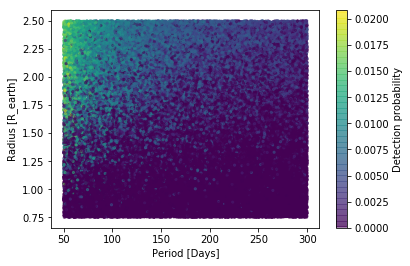

In [59]:
plt.scatter(period_samp, radius_samp, c=Q_samp, s=5, alpha=.5)
plt.xlabel("Period [Days]")
plt.ylabel("Radius [R_earth]")
plt.colorbar(label="Detection probability") # Probability of detecting planet at that period and radius

In [100]:
X_samp = np.vstack((period_samp, radius_samp, teff_samp/100)).T  # Now 1 temperature 'unit' is 100 K
bins = [np.linspace(period_rng[0], period_rng[1], 4), 
        np.linspace(radius_rng[0], radius_rng[1], 8),
        np.linspace(teff_rng[0], teff_rng[1], 3)/100]

numerator, _ = np.histogramdd(X_samp, bins, weights=Q_samp)
denominator, _ = np.histogramdd(X_samp, bins)

# Multiply the denom by the observed distribution of teffs which includes the selection function
# Need to do this for each stellar property.
denominator *= np.histogram(teff_samp/100, bins[2], normed=True)[0][None, None, :]

# broadcast the bin widths over the 8*10*2 grid then take the product to get the volume.
volume = np.prod(np.meshgrid(*map(np.diff, bins), indexing="ij"), axis=0)

numerator *= volume

integrated_det_eff = numerator/denominator

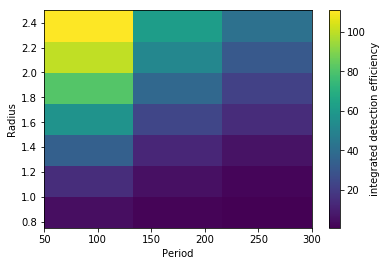

In [101]:
plt.pcolor(bins[0], bins[1], np.sum(integrated_det_eff, axis=2).T)
plt.xlabel("Period")
plt.ylabel("Radius")
plt.colorbar(label="integrated detection efficiency")  # integrated over the bin

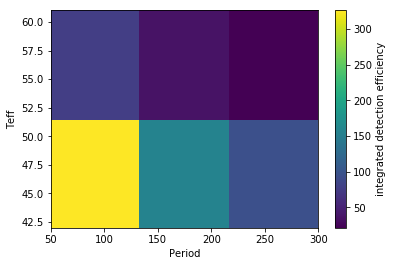

In [102]:
plt.pcolor(bins[0], bins[2], np.sum(integrated_det_eff, axis=1).T)
plt.xlabel("Period")
plt.ylabel("Teff")
plt.colorbar(label="integrated detection efficiency")  # integrated over the bin

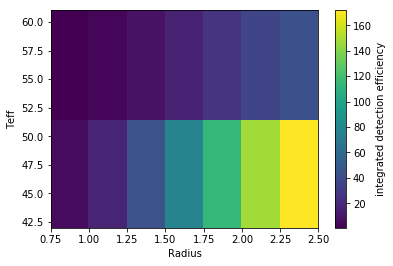

In [103]:
plt.pcolor(bins[1], bins[2], np.sum(integrated_det_eff, axis=0).T)
plt.xlabel("Radius")
plt.ylabel("Teff")
plt.colorbar(label="integrated detection efficiency")  # integrated over the bin

For each planet detected in each bin, there are _(integrated detection efficiency value - 1)_ planets you *didn't* find. Ish. Here, a temperature bin is 100 K.

Calculate the Planet occurrence rate density per bin.

In [104]:
X = np.vstack((kois.koi_period.values, kois.koi_prad.values, kois.teff.values/100)).T

Calculate the expected number of planets per unit period, per unit radius, per unit Teff.

In [111]:
hist_of_observed_planets = np.histogramdd(X, bins)[0]
theta = hist_of_observed_planets/integrated_det_eff
theta_var = theta/integrated_det_eff
theta.shape

(3, 7, 2)

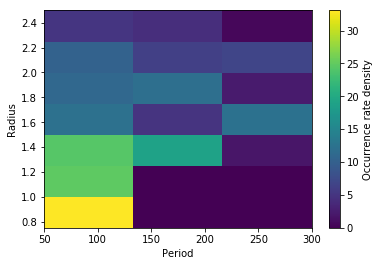

In [106]:
plt.pcolor(bins[0], bins[1], np.sum(np.diff(bins[2])[None, None, :]*theta, axis=2).T)
plt.xlabel("Period")
plt.ylabel("Radius")
plt.colorbar(label="Occurrence rate density")  # integrated over the bin

Text(0.5,0,'Radius')

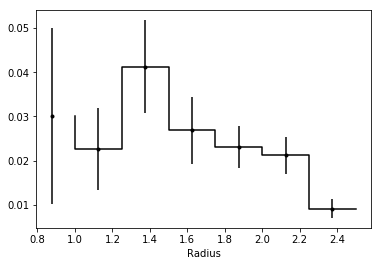

In [115]:
marg_volume = np.prod(np.meshgrid(*map(np.diff, [bins[0], bins[2]]), indexing="ij"), axis=0)
occ = np.sum(marg_volume[:, None, :]*theta, axis=(0, 2))
err = (np.sum(marg_volume[:, None, :]**2*theta_var, axis=(0, 2)))**.5
plt.step(bins[1][1:], occ/len(stlr), color="k")
plt.errorbar(.5 * (bins[1][:-1] + bins[1][1:]), occ/len(stlr), yerr=err/len(stlr), fmt="k.")
plt.xlabel("Radius")

Text(0.5,0,'Period')

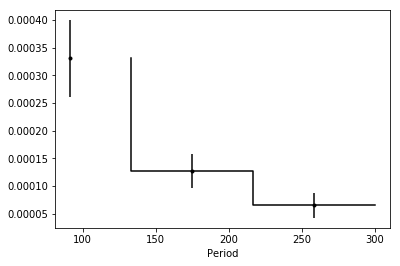

In [117]:
marg_volume = np.prod(np.meshgrid(*map(np.diff, [bins[1], bins[2]]), indexing="ij"), axis=0)
occ = np.sum(marg_volume[None, :, :]*theta, axis=(1, 2))
err = np.sqrt(np.sum(marg_volume[None, :, :]**2*theta_var, axis=(1, 2)))
plt.step(bins[0][1:], occ/len(stlr), color="k")
plt.errorbar(.5 * (bins[0][:-1] + bins[0][1:]), occ/len(stlr), yerr=err/len(stlr), fmt="k.")
plt.xlabel("Period")

Text(0.5,0,'teff')

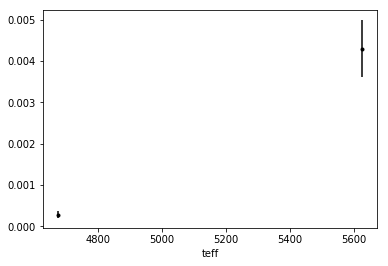

In [121]:
marg_volume = np.prod(np.meshgrid(*map(np.diff, [bins[0], bins[1]]), indexing="ij"), axis=0)
occ = np.sum(marg_volume[:, :, None]*theta, axis=(0, 1))
err = np.sqrt(np.sum(marg_volume[:, :, None]**2*theta_var, axis=(0, 1)))
# plt.scatter(.5 * (bins[2][:-1] + bins[2][1:])*100, occ/len(stlr), color="k")
plt.errorbar(.5 * (bins[2][:-1] + bins[2][1:])*100, occ/len(stlr), yerr=err/len(stlr), fmt="k.")
plt.xlabel("teff")